This notebook assesses which of the three modelling techniques - Logistic Regression, Random Forest and Gradient Boosted Trees - is best suited for the data and further model development.

**Key takeaway:**

The Gradient Boosting model shows the best performance in terms of ROC AUC and Precision-Recall curves among the three models. Other considerations favoring the Gradient Boosting model include its robustness to outliers, which is relevant given the skewed features, and its ability to handle missing values effectively (unlike logistic regression), eliminating the need for imputation or row removal.

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    average_precision_score
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [2]:
# Function to create target variable
def create_target(df):

    # Create target variable
    df['default'] = (df.amount_outstanding_21d > 0).astype(int)

    return df

In [3]:
# Function to create card expiration date
def calculate_months_to_card_expiration(df):

    """
    Calculate card_expiry_date and months_to_card_expiration between loan_issue_date and card_expiry_date.
    """
    
    # Ensure loan_issue_date is datetime
    df['loan_issue_date'] = pd.to_datetime(df['loan_issue_date'], errors='coerce')

    # Combine year and month for card expiration
    df['card_expiry_date'] = pd.to_datetime(
        df.apply(
            lambda row: f"{int(row['card_expiry_year'])}-{int(row['card_expiry_month']):02d}-01"
            if pd.notna(row['card_expiry_year']) and pd.notna(row['card_expiry_month'])
            else np.nan,
            axis=1
        ), 
        errors='coerce'
    )

    # Calculate the difference in months
    df['months_to_card_expiration'] = np.where(
        df['card_expiry_date'].notna() & df['loan_issue_date'].notna(),
        (df['card_expiry_date'].dt.year - df['loan_issue_date'].dt.year) * 12 +
        (df['card_expiry_date'].dt.month - df['loan_issue_date'].dt.month),
        np.nan
    )

     # Convert month_to_card_expiration to integer
    df['months_to_card_expiration'] = df['months_to_card_expiration'].fillna(-1).astype(int).replace(-1, np.nan)

    return df


In [4]:
def reduce_cardinality(df, n = 10):

    """ Reduce cardinality of merchant variables by grouping low frequency categories into 'Other' """

    # Merchant categories
    top_n_categories = df['merchant_category'].value_counts().nlargest(n).index

    # Merchant groups
    top_n_groups = df['merchant_group'].value_counts().nlargest(n).index

    # Reassign categories outside the top n and 'Unknown' to 'Other'
    df['merchant_category'] = df['merchant_category'].apply(
        lambda x: 'Other' if x not in top_n_categories or x == 'Unknown' else x
    )

    # Reassign groups outside the top n and 'Unknown' to 'Other'
    df['merchant_group'] = df['merchant_group'].apply(
        lambda x: 'Other' if x not in top_n_groups or x == 'Unknown' else x
    )

    return df

# Load and split data

In [5]:
# Load the data
df = pd.read_csv('data/mlcasestudy.csv')

In [6]:
# Splitting the data into train, validation and test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [7]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_full_train = df_full_train.reset_index(drop=True)


In [8]:
# Apply the processing functions to the data

# create target variable
df_train = create_target(df_train)
df_val = create_target(df_val)
df_test = create_target(df_test)
df_full_train = create_target(df_full_train)


# add months to card expiration column
df_train = calculate_months_to_card_expiration(df_train)
df_val = calculate_months_to_card_expiration(df_val)
df_test = calculate_months_to_card_expiration(df_test)
df_full_train = calculate_months_to_card_expiration(df_full_train)

# reduce cardinality of merchant variables
df_train = reduce_cardinality(df_train, n=10)
df_val = reduce_cardinality(df_val, n=10)
df_test = reduce_cardinality(df_test, n=10)
df_full_train = reduce_cardinality(df_full_train, n=10)


In [9]:
# Define helper columns
helper_columns = ['amount_outstanding_14d', 'amount_outstanding_21d', 
                  'card_expiry_month', 'card_expiry_year','card_expiry_date', 'loan_id', 'loan_issue_date']

# Extract categorical and numerical columns
categorical_features_eda = df_train.select_dtypes(include='object').columns.difference(helper_columns).tolist()
numerical_features_eda = df_train.select_dtypes(exclude='object').columns.difference(helper_columns + ['default']).tolist()


# Print categorical features 
print("\nCategorical features to explore:\n")
print("\n".join(categorical_features_eda))

# Print numerical features 
print("\nNumerical features to explore:\n")
print("\n".join(numerical_features_eda))



Categorical features to explore:

merchant_category
merchant_group

Numerical features to explore:

amount_repaid_14d
amount_repaid_1m
amount_repaid_1y
amount_repaid_3m
amount_repaid_6m
days_since_first_loan
existing_klarna_debt
loan_amount
months_to_card_expiration
new_exposure_14d
new_exposure_7d
num_active_loans
num_confirmed_payments_3m
num_confirmed_payments_6m
num_failed_payments_1y
num_failed_payments_3m
num_failed_payments_6m


Feature selection - identify highly correlated features and drop to avoid multicollinearity

In [10]:
# Compute the correlation matrix
corr_matrix = df_train[numerical_features_eda].corr()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

In [11]:

# Set the correlation threshold
threshold = 0.95

# Find index of features with correlation greater than the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

print(f'There are {len(to_drop)} columns to remove:')
print(to_drop)

There are 0 columns to remove:
[]


Finalize list of features

In [12]:
# Remove from the list of features as needed
numerical_features = [
    feature for feature in numerical_features_eda 
    if feature not in to_drop 
    #and feature not in helper_columns
]

# Remove from the list of features as needed
categorical_features = categorical_features_eda 


# Print numerical features as a vertical list
print("\nNumerical features to use in training:\n")
print("\n".join(numerical_features))

# Print categorical features as a vertical list
print("\nCategorical features to use in training:\n")
print("\n".join(categorical_features))




Numerical features to use in training:

amount_repaid_14d
amount_repaid_1m
amount_repaid_1y
amount_repaid_3m
amount_repaid_6m
days_since_first_loan
existing_klarna_debt
loan_amount
months_to_card_expiration
new_exposure_14d
new_exposure_7d
num_active_loans
num_confirmed_payments_3m
num_confirmed_payments_6m
num_failed_payments_1y
num_failed_payments_3m
num_failed_payments_6m

Categorical features to use in training:

merchant_category
merchant_group


In [13]:

# Assert that 'default' is not in numerical_features
assert 'default' not in numerical_features, "'default' is still in numerical_features!"


In [14]:
# Get all columns in df_train
all_columns = set(df_train.columns)

# Combine numerical_features and categorical_features
selected_features = set(numerical_features + categorical_features)

# Find columns that are not in either list
not_in_training = all_columns - selected_features

# Print the result
print("\nColumns not included in training:\n")
print("\n".join(sorted(not_in_training)))




Columns not included in training:

amount_outstanding_14d
amount_outstanding_21d
card_expiry_date
card_expiry_month
card_expiry_year
default
loan_id
loan_issue_date


# Preprocessing pipeline

Define the steps to prepare data for training and evaluation

In [15]:
# Create transformations for each type of features

# Numerical features - no processing
numerical_transformer = 'passthrough'

# Categorical features - one-hot encoding ignoring unknown categories
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [16]:
# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



In [17]:
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

Apply preprocessing

In [18]:
# Transform training data
X_train_transformed = preprocessing_pipeline.fit_transform(df_train[numerical_features + categorical_features])
y_train = df_train['default'].values

# Transform validation data
X_val_transformed = preprocessing_pipeline.transform(df_val[numerical_features + categorical_features])
y_val = df_val['default'].values

In [19]:
# Get feature names from the preprocessing pipeline
numerical_features_transformed = numerical_features 

categorical_features_transformed = preprocessing_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(categorical_features)

# Combine numerical and transformed categorical feature names
all_feature_names = list(numerical_features_transformed) + list(categorical_features_transformed)

In [20]:
all_feature_names

['amount_repaid_14d',
 'amount_repaid_1m',
 'amount_repaid_1y',
 'amount_repaid_3m',
 'amount_repaid_6m',
 'days_since_first_loan',
 'existing_klarna_debt',
 'loan_amount',
 'months_to_card_expiration',
 'new_exposure_14d',
 'new_exposure_7d',
 'num_active_loans',
 'num_confirmed_payments_3m',
 'num_confirmed_payments_6m',
 'num_failed_payments_1y',
 'num_failed_payments_3m',
 'num_failed_payments_6m',
 'merchant_category_Concept Stores & Miscellaneous',
 'merchant_category_Diversified Jewelry & Accessories',
 'merchant_category_Event - Broker & Agencies',
 'merchant_category_Food & Beverage',
 'merchant_category_Furniture',
 'merchant_category_General Shoes & Clothing',
 'merchant_category_Other',
 'merchant_category_Sports Gear & Outdoor',
 'merchant_category_Travel - Accommodation & Resorts',
 'merchant_category_Youthful Shoes & Clothing',
 'merchant_group_Clothing & Shoes',
 'merchant_group_Electronics',
 'merchant_group_Food & Beverage',
 'merchant_group_Health & Beauty',
 'mercha

# Train models and select the best model

## Train models

In [21]:
# Initialize a dictionary to store the best models and their scores
best_models = {}

Logistic Regression

In [22]:
### Logistic Regression ###
pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    #('imputer', SimpleImputer(strategy='median')), # filling missing values with median didn't improve the model
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression(max_iter=1000))
])

param_grid_lr = {
    'model__C': [0.1, 1, 10, 100]
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, scoring='roc_auc', cv=4, verbose=1)
grid_search_lr.fit(X_train_transformed, y_train)

# Store the best Logistic Regression model and its AUC score
best_models['Logistic Regression'] = {
    'model': grid_search_lr.best_estimator_,
    'auc': grid_search_lr.best_score_
}

print("Best Logistic Regression parameters:", grid_search_lr.best_params_)
print("Best Logistic Regression AUC:", grid_search_lr.best_score_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best Logistic Regression parameters: {'model__C': 1}
Best Logistic Regression AUC: 0.649048916551872


Random Forest

In [23]:
### Random Forest ###
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 6, 9],
    'model__min_samples_leaf': [1, 2, 5] # min number of samples in a leaf node to discourage splits that lead to very small leaf nodes that are likely overfit nouse in the training data
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, scoring='roc_auc', cv=4, verbose=1)
grid_search_rf.fit(X_train_transformed, y_train)

# Store the best Random Forest model and its AUC score
best_models['Random Forest'] = {
    'model': grid_search_rf.best_estimator_,
    'auc': grid_search_rf.best_score_
}

print("Best Random Forest parameters:", grid_search_rf.best_params_)
print("Best Random Forest AUC:", grid_search_rf.best_score_)


Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best Random Forest parameters: {'model__max_depth': 9, 'model__min_samples_leaf': 5, 'model__n_estimators': 200}
Best Random Forest AUC: 0.6739732387442309


Gradient Boosted Trees

In [24]:

### XGBoost Tuning ###
pipeline_xgb = Pipeline([
    ('model', xgb.XGBClassifier(objective='binary:logistic')) 
   
])

param_grid_xgb = {
    
    'model__n_estimators': [50, 100, 200], # number of trees
    'model__eta': [0.01, 0.1, 0.2], # contribution of each tree
    'model__max_depth': [3, 6, 9], # max number of splits
    'model__min_child_weight': [3, 5, 7], # min amount of data in leaf node
}

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, scoring='roc_auc', cv=4, verbose=1)
grid_search_xgb.fit(X_train_transformed, y_train)

# Store the best XGBoost model and its AUC score
best_models['XGBoost'] = {
    'model': grid_search_xgb.best_estimator_,
    'auc': grid_search_xgb.best_score_
}

print("Best XGBoost parameters:", grid_search_xgb.best_params_)
print("Best XGBoost AUC:", grid_search_xgb.best_score_)


Fitting 4 folds for each of 81 candidates, totalling 324 fits
Best XGBoost parameters: {'model__eta': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 3, 'model__n_estimators': 100}
Best XGBoost AUC: 0.6816747243946195


## Evaluate models on the validation data

In [25]:
# Get predictions for each model
y_pred_lr = best_models['Logistic Regression']['model'].predict_proba(X_val_transformed)[:, 1]
y_pred_rf = best_models['Random Forest']['model'].predict_proba(X_val_transformed)[:, 1]
y_pred_gbm = best_models['XGBoost']['model'].predict_proba(X_val_transformed)[:, 1]


ROC Curve

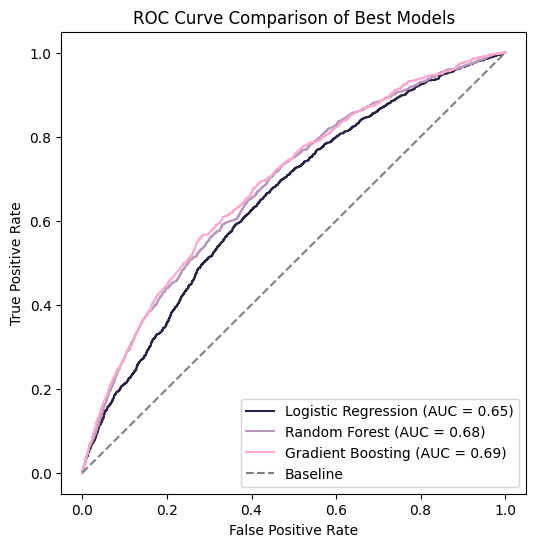

In [26]:

# Calculate ROC curve values
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_rf)
fpr_gbm, tpr_gbm, _ = roc_curve(y_val, y_pred_gbm)

# Plot ROC curves 
plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, color = '#2C2242', label=f'Logistic Regression (AUC = {roc_auc_score(y_val, y_pred_lr):.2f})')
plt.plot(fpr_rf, tpr_rf, color = '#B798BE', label=f'Random Forest (AUC = {roc_auc_score(y_val, y_pred_rf):.2f})')
plt.plot(fpr_gbm, tpr_gbm, color = '#FFA8CD', label=f'Gradient Boosting (AUC = {roc_auc_score(y_val, y_pred_gbm):.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline')

# Configure the plot
plt.title('ROC Curve Comparison of Best Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Precision-Recall Curve

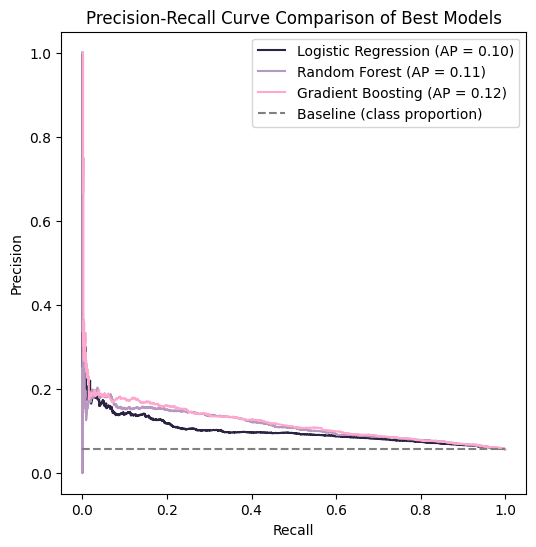

In [27]:
# Get precision-recall values for each model
precision_lr, recall_lr, _ = precision_recall_curve(y_val, y_pred_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_val, y_pred_rf)
precision_gbm, recall_gbm, _ = precision_recall_curve(y_val, y_pred_gbm)

# Calculate Average Precision (AP) scores
ap_lr = average_precision_score(y_val, y_pred_lr)
ap_rf = average_precision_score(y_val, y_pred_rf)
ap_gbm = average_precision_score(y_val, y_pred_gbm)

# Calculate the baseline precision line
baseline_class_proportion = y_val.mean()  # Propotion of default 


# Plot precision-recall curves 
plt.figure(figsize=(6, 6))
plt.plot(recall_lr, precision_lr, color = '#2C2242', label=f'Logistic Regression (AP = {ap_lr:.2f})')
plt.plot(recall_rf, precision_rf, color = '#B798BE', label=f'Random Forest (AP = {ap_rf:.2f})')
plt.plot(recall_gbm, precision_gbm, color = '#FFA8CD', label=f'Gradient Boosting (AP = {ap_gbm:.2f})')
plt.hlines(baseline_class_proportion, xmin=0, xmax=1, color='gray', linestyle='--', label='Baseline (class proportion)')

# Configure the plot
plt.title('Precision-Recall Curve Comparison of Best Models')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.show()




In [28]:
# The jump: the model making no positive predictions at the highest threshold.

# ---------
# Precision is 1: no False Positives when threshold is high
# Recall is 0: no True Positives when threshold is high

# print(classification_report(y_val, y_pred_gbm > 0.2))

# # confusion matrix
# cm_gbm = confusion_matrix(y_val, y_pred_gbm > 0.2)
# print(cm_gbm)

# print(classification_report(y_val, y_pred_gbm > 0.353))
# #print(classification_report(y_val, y_pred_lr >= 1))

# cm_gbm = confusion_matrix(y_val, y_pred_gbm > 0.353)
# print(cm_gbm)

# print(classification_report(y_val, y_pred_gbm > y_pred_gbm.max()))
# #print(classification_report(y_val, y_pred_lr >= 1))

# cm_gbm = confusion_matrix(y_val, y_pred_gbm > y_pred_gbm.max())
# print(cm_gbm)

# # cm_lr = confusion_matrix(y_val, y_pred_lr > 0.5)
# # print(cm_lr)

# tn, fp, fn, tp = confusion_matrix(y_val, y_pred_gbm > 0.33).ravel()
# tn, fp, fn, tp


## Select the best model

The Gradient Boosting model shows the best performance in terms of ROC AUC and Precision-Recall curves among the three models. Other considerations favoring the Gradient Boosting model include its robustness to outliers, which is relevant given the skewed features, and its ability to handle missing values effectively (unlike logistic regression), eliminating the need for imputation or row removal.

In [29]:
best_model = best_models['XGBoost']['model']

# Train the best model on the full training data

### Final training data

In [30]:
# Transform full training data
X_full_train_transformed = preprocessing_pipeline.fit_transform(df_full_train[numerical_features + categorical_features])
y_full_train = df_full_train['default'].values

# Transform test data
X_test_transformed = preprocessing_pipeline.transform(df_test[numerical_features + categorical_features])
y_test = df_test['default'].values


In [31]:
# Fit the best model on the full training data
best_model.fit(X_full_train_transformed, y_full_train)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.1,
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [32]:
# AUC score on full training data
cv_auc = cross_val_score(best_model, X_full_train_transformed, y_full_train, cv=5, scoring='roc_auc')
print(f"Cross-validated AUC on full training data: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")



Cross-validated AUC on full training data: 0.6833 ± 0.0104


In [33]:
y_pred = best_model.predict_proba(X_test_transformed)[:, 1]

In [34]:
# Final AUC score on test data
auc = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc}")

Test AUC: 0.6852111996364223


Save curves to compare with other models in model development

In [35]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
ap_gbm = average_precision_score(y_test, y_pred)

In [36]:
# Create a dictionary to store the metrics
roc_pr_data = {
    'roc': {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'roc_auc': roc_auc},
    'pr': {'precision': precision.tolist(), 'recall': recall.tolist(), 'ap': ap_gbm}
}

# Save to JSON file
with open('model_spec_step2_metrics.json', 'w') as f:
    json.dump(roc_pr_data, f)

print("Metrics saved to model_spec_step2_metrics.json")


Metrics saved to model_spec_step2_metrics.json


# Feature importance

In [37]:
# Verify ferature names
instance_idx = 5

feature_values = zip(all_feature_names, X_full_train_transformed[instance_idx, :])

# Display feature values in a readable format
print(f"Feature values for instance {instance_idx}:")
for feature_name, feature_value in feature_values:
    print(f"{feature_name}: {feature_value}")

Feature values for instance 5:
amount_repaid_14d: 0.0
amount_repaid_1m: 0.0
amount_repaid_1y: 3628.0
amount_repaid_3m: 0.0
amount_repaid_6m: 3628.0
days_since_first_loan: 170.0
existing_klarna_debt: 0.0
loan_amount: 4718.0
months_to_card_expiration: 4.0
new_exposure_14d: 0.0
new_exposure_7d: 0.0
num_active_loans: 0.0
num_confirmed_payments_3m: 0.0
num_confirmed_payments_6m: 4.0
num_failed_payments_1y: 0.0
num_failed_payments_3m: 0.0
num_failed_payments_6m: 0.0
merchant_category_Concept Stores & Miscellaneous: 0.0
merchant_category_Diversified Jewelry & Accessories: 0.0
merchant_category_Event - Broker & Agencies: 0.0
merchant_category_Food & Beverage: 0.0
merchant_category_Furniture: 0.0
merchant_category_General Shoes & Clothing: 1.0
merchant_category_Other: 0.0
merchant_category_Sports Gear & Outdoor: 0.0
merchant_category_Travel - Accommodation & Resorts: 0.0
merchant_category_Youthful Shoes & Clothing: 0.0
merchant_group_Clothing & Shoes: 1.0
merchant_group_Electronics: 0.0
merchan

In [38]:
df[(df.loan_amount == 4718.0) & (df.amount_repaid_1y == 3628.0)]

,loan_id,loan_issue_date,loan_amount,amount_outstanding_14d,amount_outstanding_21d,card_expiry_month,card_expiry_year,existing_klarna_debt,num_active_loans,days_since_first_loan,...,num_failed_payments_3m,num_failed_payments_6m,num_failed_payments_1y,amount_repaid_14d,amount_repaid_1m,amount_repaid_3m,amount_repaid_6m,amount_repaid_1y,merchant_group,merchant_category
53334,b6e6bf6717661225bd8f572a63bea119,2023-09-03,4718,0,0,1.0,2024.0,0.0,0,170,...,0,0,0,0,0,0,3628,3628,Clothing & Shoes,General Shoes & Clothing


Shapley values

In [39]:
# Extract the model object from the pipeline
model_object = best_model.named_steps['model']

In [40]:

# Create SHAP TreeExplainer for the tree-based model
explainer = shap.TreeExplainer(model_object)

# Calculate SHAP values
shap_values = explainer.shap_values(X_full_train_transformed)

# Wrap shap_values into an Explanation object
shap_values_with_names = shap.Explanation(
    values=shap_values,                   # SHAP values matrix
    base_values=explainer.expected_value, # Base values
    data=X_full_train_transformed,         # Transformed feature values
    feature_names=all_feature_names       # Feature names
)


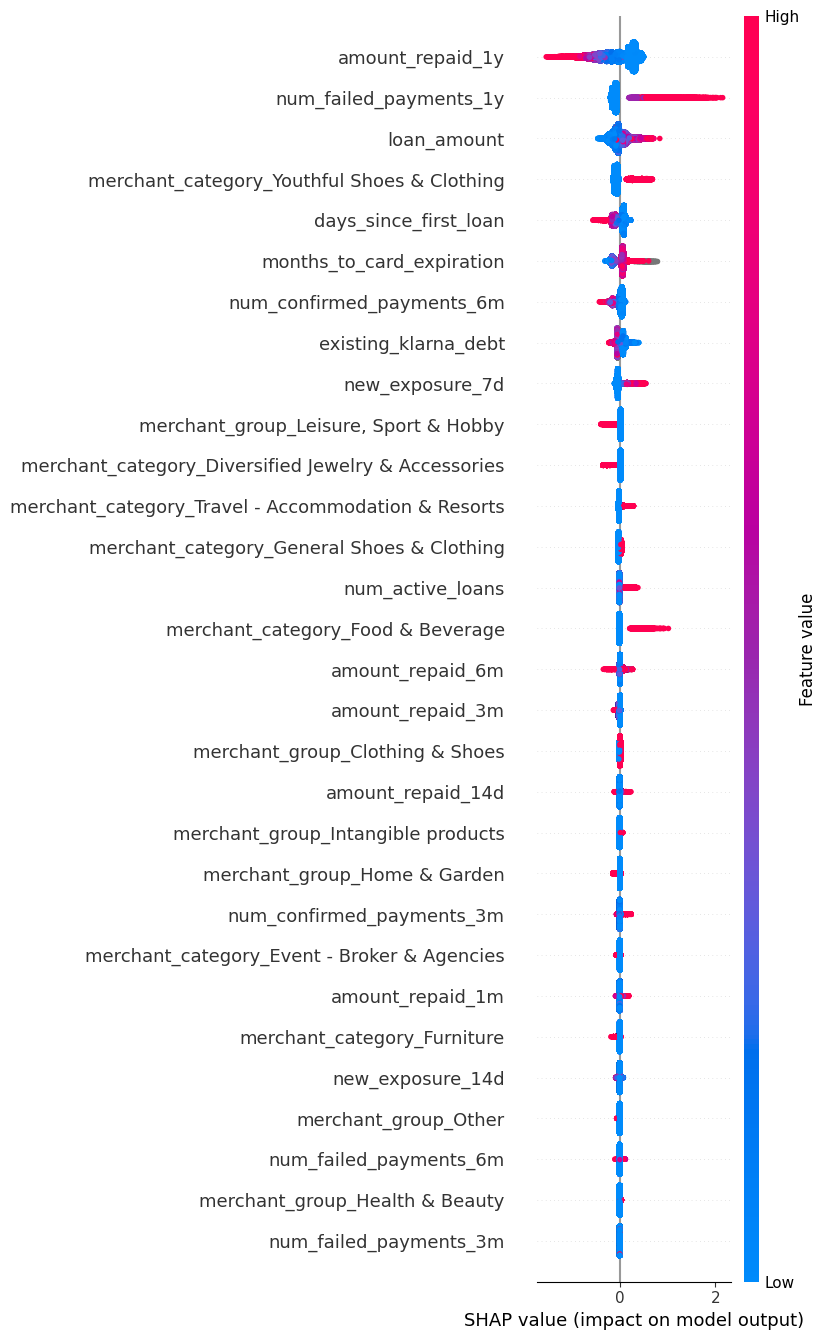

In [41]:
#  Density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output
shap.summary_plot(shap_values_with_names, X_full_train_transformed, max_display = 30)